# Internal documentation
This document gives a tour of the code in the `MDSINE2` package and how it interacts with `MDSINE2_Paper` package. The first part of the tutorial is giving a high level tour of the `MDSINE2` package. The next part shows how to run selected analyses with the code. The last part of the tour shows where specific functions are implemented in the code that are used often

### Table of contents
* [High level tour](#highleveltour)
    * [Datatypes](#datatypes)
        - [`md2.Taxon` and `md2.OTU`](#taxonandotu)
        - [`md2.TaxaSet`](#taxaset)
        - [`md2.Study` and `md2.Subject`](#studyandsubject)
        - [`md2.Perturbations` and `md2.BasePerturbation`](#perturbationsandbaseperturbatio)
        - [Everything is connected to each other through the `Study` class](#everythingisconnected)
    * [`Graph` object](#graphobject)
    * [`DataNode` object](#datanodeobject)
    * [`md2.Clustering` object](#clusteringobject)
    * [`md2.Interactions` object](#interactionsobject)
    * [`md2.BaseMCMC` and `md2.Tracer` object](#basemcmcandtracerobject)
* [Common functionality](#commonfunctionality)
    * [Reading in the gibson dataset](#readinginthegibsondataset)
    * [Retrieve trace from disk](#retrievetracefromdisk)
    * [Get statistics of a trace](#getstatisticsofatrace)
    * [Defining the parameters of the model](#definingtheparametersofthemodel)
    * [Bayes factors](#bayesfactors)
    * [Condensing fixed cluster interactions in perturbations into cluster-cluster interactions](#condensingfixedcluster)
    * [Forward simulating](#forwardsimulating)

# High level tour <a class="anchor" id="highleveltour"></a>
The purpose of this section is to take a deep dive into the core code of MDSINE2

In [1]:
import mdsine2 as md2
from mdsine2.names import STRNAMES
import numpy as np

## Datatypes <a class="anchor" id="datatypes"></a>
Data is parsed into various python objects depending on the type of data:

### `md2.Taxon` and `md2.OTU` <a class="anchor" id="taxonandotu"></a>
The first datatypes are the `md2.Taxon` (location in code: `md2.pylab.base.Taxon`) and `md2.OTU` (location in code: `md2.pylab.base.OTU`) objects. These objects contain the OTU and Taxon specific data and can be referenced with internal parameters such as:
 - `taxonomy` (`dict`: `str` -> `str`): This dictionary maps the taxonomic level to the taxonomic classification of the OTU/taxon.
 - `sequence` (`str`): This is the sequence of the taxa/OTU

An `OTU` is distinct from a `Taxon` object in the sense that an OTU is comprised of multiple `Taxon`s and contains all of the information for each one. Additionally, you can set the consensus taxonomy into the `taxonomy` parameter and the consensus sequence into the `sequence` parameter. This two objects are treated identically in the code.

### `md2.TaxaSet` <a class="anchor" id="taxaset"></a>
The next datatype is the `md2.TaxaSet` (location in code: `md2.pylab.base.TaxaSet`) object. This object works as an aggregator of the `md2.OTU` and `md2.Taxon` objects. The primary use of this object is reference all of the `OTU` and `Taxon` objects and to keep them in order. You can "get" the individual taxa by indexing it directly:

In [3]:
# Get the TaxaSet object for the UC gibson dataset (these commands are the same for any dataset)
study = md2.dataset.load_gibson(dset='uc') # description of the `Study` object is below
taxa = study.taxa

# Index a taxon directly
taxon = taxa['ASV_1']
print(taxon)

# subfields
print('taxonomy')
print(type(taxon.taxonomy))
print(taxon.taxonomy.keys())
print('\nsequence')
print(type(taxon.sequence))
print(taxon.sequence)

Taxon
	id: 1279996991808
	idx: 0
	name: ASV_1
	taxonomy:
		kingdom: Bacteria
		phylum: Bacteroidetes
		class: Bacteroidia
		order: Bacteroidales
		family: Bacteroidaceae
		genus: Phocaeicola
		species: NA
taxonomy
<class 'dict'>
dict_keys(['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'asv'])

sequence
<class 'str'>
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAACAGG


We can index the same taxon by the Python ID (`id`) or the index (`idx`) that the taxon/OTU appears in order of the others in the same way that we index by the name:

In [4]:
taxon = taxa[0]
print('Retrieving with index')
print(taxon)

ID = taxon.id
print('Retrieving with python id')
taxon = taxa[ID]
print(taxon)

Retrieving with index
Taxon
	id: 1279996991808
	idx: 0
	name: ASV_1
	taxonomy:
		kingdom: Bacteria
		phylum: Bacteroidetes
		class: Bacteroidia
		order: Bacteroidales
		family: Bacteroidaceae
		genus: Phocaeicola
		species: NA
Retrieving with python id
Taxon
	id: 1279996991808
	idx: 0
	name: ASV_1
	taxonomy:
		kingdom: Bacteria
		phylum: Bacteroidetes
		class: Bacteroidia
		order: Bacteroidales
		family: Bacteroidaceae
		genus: Phocaeicola
		species: NA


Additionally with indexiing the taxa from the `TaxaSet` object, we can also iterate over the taxa in order:

In [5]:
# Print the first 4 taxa
for taxon in taxa:
    if taxon.idx > 3:
        break
    print(taxon)

Taxon
	id: 1279996991808
	idx: 0
	name: ASV_1
	taxonomy:
		kingdom: Bacteria
		phylum: Bacteroidetes
		class: Bacteroidia
		order: Bacteroidales
		family: Bacteroidaceae
		genus: Phocaeicola
		species: NA
Taxon
	id: 1279996991920
	idx: 1
	name: ASV_2
	taxonomy:
		kingdom: Bacteria
		phylum: Bacteroidetes
		class: Bacteroidia
		order: Bacteroidales
		family: Bacteroidaceae
		genus: Bacteroides
		species: ovatus/fragilis
Taxon
	id: 1279996991696
	idx: 2
	name: ASV_3
	taxonomy:
		kingdom: Bacteria
		phylum: Verrucomicrobia
		class: Verrucomicrobiae
		order: Verrucomicrobiales
		family: Akkermansiaceae
		genus: Akkermansia
		species: muciniphila
Taxon
	id: 1279996991752
	idx: 3
	name: ASV_4
	taxonomy:
		kingdom: Bacteria
		phylum: Bacteroidetes
		class: Bacteroidia
		order: Bacteroidales
		family: Bacteroidaceae
		genus: Bacteroides
		species: NA


Another useful tool for using `TaxaSet` is reverse indexing. This is where we take the name or the Python ID of the taxon and we want to get the index:

In [6]:
# Get a random taxon
taxon = taxa['ASV_111']
print(taxon)
name = taxon.name
ID = taxon.id

print(taxa.names.index[name])
print(taxa.ids.index[ID])

Taxon
	id: 1279997032096
	idx: 110
	name: ASV_111
	taxonomy:
		kingdom: Bacteria
		phylum: Firmicutes
		class: Clostridia
		order: Clostridiales
		family: Lachnospiraceae
		genus: Blautia
		species: NA
110
110


We use the `TaxaSet` object to read from a taxonomic table (`md2.TaxaSet.parse`) and to write it's internal state to a table (`md2.TaxaSet.write_taxonomy_to_csv`). The order of the Taxa is __strictly dependent on their order in this object__ - all other classes (`md2.Clustering`, `md2.Study`, etc.) depend on this ordering.

### `md2.Study` and `md2.Subject` <a class="anchor" id="studyandsubject"></a>

The next objects are the `md2.Study` (location in code: `mdsine2.pylab.base.Study`) and `md2.Subject` (location in code: `mdsine2.pylab.base.Subject`) objects. These objects read in the reads and qPCR measurements for each subject, and reference the `md2.TaxaSet` object and `md2.Perturbations` object (referenced below), and how we generate matrices.

A `md2.Subject` object contains all of the information regarding a single subject in a dataset, such as:
 * `times` (`np.ndarray`): This stores the timepoints contained for this subject in order. These times map to the qPCR and reads for those time points.
 * `reads` (`dict`: `float` -> `np.ndarray`): This maps the timepoint to an array of counts for each taxa. The order of the array corresponds to the order of the taxa in the `md2.TaxaSet` object.
 * `qpcr` (`dict`: `float` -> `md2.qPCRdata`): Maps the timepoint to the qPCR measurement. The `md2.qPCRdata` object (location in code: `mdsine2.pylab.base.qPCRData`) stores the information for the triplicate qPCR measurements. 
 * `perturbations` (`md2.Perturbations`): References all of the perturbations in the study

In [7]:
# Get the 4th subject (just an example)
subject = study[4]

print('subject name:', subject.name)
for i, t in enumerate(subject.times):
    if i > 3:
        break
    print('\nTime {}'.format(t))
    print('reads', subject.reads[t]) # These are the reads
    print(len(subject.reads[t]), len(subject.taxa)) # These are equal
    print('qPCR:', subject.qpcr[t].data) # These are the triplicate qPCR measurements

subject name: 9

Time 0.0
reads [150 343  21 ...   0   0   0]
1473 1473
qPCR: [ 7158224.75044306 21449824.45947887  7026214.74028283]

Time 0.5
reads [927 411  21 ...   0   0   0]
1473 1473
qPCR: [3.65801801e+09 4.40176703e+09 6.46110522e+09]

Time 1.0
reads [36037  2819    32 ...     0     0     0]
1473 1473
qPCR: [1.02195918e+10 1.72985110e+10 1.51350301e+10]

Time 1.5
reads [28263  5178   119 ...     0     0     0]
1473 1473
qPCR: [3.06884858e+10 7.59445116e+10 6.77454856e+10]


Given that we have all of this information for the subject, we can create matrices of the counts, relative abundances, and absolute abundances (multiplying the relative abundance by the qPCR mean). This is done with the `matrix` and `df` function. The `matrix` function makes the abundance table for each taxa in order for each time in order. It returns 3 types of abundances: 
1. `'raw'`: These are the raw counts for each taxa
2. `'rel'`: These are the relative abundances for each taxa
3. `'abs'`: These are the absolute abundances for each taxa

The `df` function just wraps the `matrix` function and adds the taxa names as the index and the times as the columns for a `pandas.DataFrame`:

In [8]:
print('absolute abundance')
print(subject.matrix()['abs'])
df = subject.df()['abs']
df.head()

absolute abundance
[[3.10227753e+05 1.35872110e+08 9.55686446e+09 ... 5.56451703e+10
  4.31226057e+10 2.92904389e+10]
 [7.09387463e+05 6.02410327e+07 7.47587227e+08 ... 1.25140774e+10
  2.37771086e+10 1.84579855e+10]
 [4.34318855e+04 3.07800897e+06 8.48626863e+06 ... 1.27296188e+09
  3.43757415e+09 7.08885867e+09]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,58.5,59.0,59.5,60.0,60.5,61.0,62.0,63.0,64.0,64.5
ASV_1,310227.753446,1.358721e+08,9.556864e+09,2.927902e+10,4.020405e+10,3.708254e+10,5.754406e+08,1.046794e+10,6.230351e+10,4.522686e+09,...,4.316884e+10,1.310502e+11,1.355388e+10,1.337335e+10,2.661841e+10,1.418362e+10,3.905077e+10,5.564517e+10,4.312261e+10,2.929044e+10
ASV_2,709387.462879,6.024103e+07,7.475872e+08,5.364143e+09,1.637791e+10,2.128136e+10,3.272162e+08,7.426126e+09,4.796694e+10,4.036937e+09,...,4.873706e+10,1.025128e+11,1.522994e+10,6.159113e+09,1.503570e+10,2.482822e+09,7.512273e+09,1.251408e+10,2.377711e+10,1.845799e+10
ASV_3,43431.885482,3.078009e+06,8.486269e+06,1.232779e+08,7.966482e+09,3.227539e+10,3.426462e+08,1.393619e+10,4.409241e+10,8.937856e+09,...,4.733425e+07,0.000000e+00,1.695446e+07,1.189346e+07,7.704687e+06,4.526567e+07,2.140830e+07,1.272962e+09,3.437574e+09,7.088859e+09
ASV_4,31022.775345,1.172575e+06,1.591175e+06,0.000000e+00,6.819158e+06,0.000000e+00,0.000000e+00,3.589581e+06,1.659325e+07,0.000000e+00,...,1.204872e+08,1.763205e+08,3.956040e+07,1.245982e+07,2.439818e+07,9.430347e+06,2.344718e+07,6.085874e+07,6.649080e+07,5.366734e+07
ASV_5,33090.960368,1.612290e+06,0.000000e+00,2.486277e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,8.495329e+06,2.568229e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


We can also produce these matrices clustered at a specific taxonomic level. We can only do this if taxonomic information is available for the taxa. Note that you can make the `index_formatter` whatever you want as long as the taxonomic level is above or equal to the taxonomic level `taxlevel` you are aggregating to:

In [9]:
df, _ = subject.cluster_by_taxlevel(dtype='abs', taxlevel='family', index_formatter='%(order)s %(family)s')
df.head()

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,58.5,59.0,59.5,60.0,60.5,61.0,62.0,63.0,64.0,64.5
Bacteroidaceae Bacteroidia,3.034027e+06,3.500136e+08,1.268299e+10,4.454062e+10,7.430666e+10,7.934913e+10,1.222880e+09,2.561669e+10,1.569016e+11,1.331800e+10,...,1.125996e+11,2.775373e+11,3.534197e+10,2.194740e+10,4.846120e+10,1.749254e+10,4.865698e+10,7.254361e+10,7.899771e+10,5.742047e+10
Akkermansiaceae Verrucomicrobiae,7.652285e+04,4.690299e+06,8.486269e+06,1.522845e+08,8.292097e+09,3.354910e+10,3.560853e+08,1.446458e+10,4.582641e+10,9.285970e+09,...,4.733425e+07,0.000000e+00,1.695446e+07,2.038879e+07,3.338698e+07,4.526567e+07,2.140830e+07,1.272962e+09,3.437574e+09,7.088859e+09
Sutterellaceae Betaproteobacteria,3.102278e+04,8.794311e+05,9.679650e+07,1.714495e+09,5.126302e+09,6.476278e+09,7.344197e+07,7.861183e+08,6.508702e+09,7.456093e+08,...,1.811611e+09,1.887511e+10,3.816367e+09,2.541802e+09,5.849142e+09,6.518256e+08,6.680408e+09,1.622392e+10,1.359404e+10,1.303878e+10
Enterobacteriaceae Gammaproteobacteria,3.102278e+05,5.276587e+06,1.644215e+07,8.909159e+07,0.000000e+00,1.177811e+07,5.226301e+05,3.302415e+07,2.406021e+08,4.552805e+06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.607342e+06,0.000000e+00,0.000000e+00
Porphyromonadaceae Bacteroidia,2.212958e+05,2.608979e+07,2.116263e+08,2.056358e+09,4.677943e+09,4.285549e+09,6.607537e+07,4.989518e+08,8.010392e+09,9.988153e+08,...,1.092130e+10,3.230192e+10,2.681226e+09,2.888412e+09,4.670325e+09,1.971697e+09,7.286976e+09,7.982637e+09,6.559317e+09,4.238527e+09


The `md2.Study` object is an object that references multiple `Subject` objects and contains all of the information used in a study. Most of the major commands are done through the `Study` object so that all of the various data structures stay consistent with each other. You can index a subject both with its index and its name:

In [10]:
subj = study[2]
print(subj.name)
subj = study[subj.name]
print(subj.name)

7
7


It is with the `Study` object that we do the majority of the parsing of the tables (`md2.Study.parse`). We can also remove certain data from the study manually:
* Remove timepoints with `study.pop_times`
* Remove subjects with `study.pop_subjects`
* Remove taxa with `stuy.pop_taxa`

In [11]:
study = md2.dataset.load_gibson(dset='uc')
print('removing subject 10')
print('number of subjects:', len(study))
study.pop_subject('10')
print('number of subjects:', len(study))

subject = study['6']

print('Removing the timepoint 1 from all subjects')
print(subject.times)
study.pop_times(1)
print(subject.times)



removing subject 10
number of subjects: 5
number of subjects: 4
Removing the timepoint 1 from all subjects
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.
  9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5
 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.
 50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5
 60.  60.5 61.  62.  63.  64.  64.5]
[ 0.   0.5  1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.
 10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.
 28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.
 37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.
 50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.
 60.5 61.  62.  63.  64.  64.5]


We can also create numpy matrices and `DataFrame`s of the data at the study level using `study.matrix` and `study.df`. This works the same the `matrix` and `df` functions for the `Subject` object but this will aggregate the different subjects together in a way that you describe. See documentation for details.

Another key feature of the `Study` object is the `study.normalize_qpcr` and `study.denormalize_qpcr` functions. These are used to rescale the data either higher or lower. This is done for numerical reasons during inference. We learn the parameters in normalized space, and then we denormalize then with the function `mdsine2.run.denormalize_parameters`.

### `md2.Perturbations` and `md2.BasePerturbation` <a class="anchor" id="perturbationsandbaseperturbatio"></a>
The last core data structure used to wrap the raw data are the `md2.Perturbations` (location in code: `mdsine2.pylab.base.Perturbations`) object and the `md2.BasePerturbation` (location in code: `mdsine2.pylab.base.BasePerturbation`) object. These hold the information for what subject has what perturbation.

The `BasePerturbation` class is analogous to the `Subject` class in the sense that it stores in the information needed for a single perturbation. Internal parameters include:
 * `name` (`str`): This is the name of the perturbation
 * `starts` (`dict`: `str` -> `float`): This maps the name of the subject that has this perturbation to the start time of the perturbation
 * `ends` (`dict`: `str` -> `float`): This maps the name of the subject that has this perturbation to the end time of the perturbation
 
The `Perturbations` class is analogous to the `Study` class in the sense that it agglomerates many perturbations. You can index the perturbations by their name, Python ID, or their index.
 

### Everything is connected to each other through the `Study` class <a class="anchor" id="everythingisconnected"></a>

The `Study` object connects all of the aggregator classes together:
 * `study.perturbations` -> `Perturbations`
 * `study.taxa` -> `TaxaSet`
 
Each subject also has the `.perturbations` and `.taxa` pointer but as a `@property` so that it points to the same pointer that the study object is:
```python

class Subject(Saveable):
    
    ...
    
    @property
    def perturbations(self) -> Perturbations:
        return self.parent.perturbations

    @property
    def taxa(self) -> TaxaSet:
        return self.parent.taxa
    
    ...

```

When we make changes to the data as a whole, 99% of the time this is done with the `Study` object so that everything can stay consistent. For example, when we remove taxa from the inference, the `Study` object removes the reads at the respective indices in each subject, tells the `TaxaSet` object to remove that from the set, and tells it to reorder the indices of the taxa so that they are sequential again.

## `Graph` object <a class="anchor" id="graphobject"></a>

The `md2.Graph` (location in code: `mdsine2.pylab.graph.Graph`) is a compute graph that references the variables and objects used during inference. When we build the graph during inference, we are initializing the inference objects within this graph.

This object can be accessed within each object using the `.G` pointer or within the `BaseMCMC` object (described below) with the pointer `.graph`. To access objects, use the `__getitem__` function in python:
```python
    growth = mcmc.graph[STRNAMES.GROWTH_VALUE]
    clustering = growth.G[STRNAMES.CLUSTERING]
```

## `DataNode` object  <a class="anchor" id="datanodeobject"></a>
The `md2.design_matrices` module describes the objects that are used to make the regression matrices during inference. The `mdsine2.DataNode` (location in code: `mdsine2.pylab.graph.DataNode`) is a base class that is used to set the `.data` pointer in the `Graph` object:
```python
data = mcmc.graph.data
data = growth.G.data
```
This object references the objects that build the regression matrices using the current values of the latent trajectory. Each variable has its own design matrix that builds these matrices and can all be found in the `mdsine2.design_matrices` folder. These objects are initialized in `mdsine2.run.initialize_graph` and are constantly updated during inference when values are updated or the latent state changes.

To access these files, use their name of the respective variable they build for:
```python
growth_design_matrix = mcmc.graph.data.design_matrices[STRNAMES.GROWTH_VALUE]
```
This accesses the `mdsine2.design_matrices.GrowthDesignMatrix` object. This is analugous for the other design matrices.

In the case for the interactions and perturbations, the design matrices are composed of 3 different components that have the following relationship:

\\[ \text{DesignMatrix} = \text{BaseDesignMatrix} \times \text{MixingDesignMatrix} \\]

* `*BaseDesignMatrix`: This objects builds the perturbation or interaction matrices as if it were only building for the taxon-taxon relationships. These matrices do not take into account the indicators.
* `*MixingDesignMatrix`: This object aggregates the taxon-taxon relationships into cluster-cluster relationships and selects which ones to return based on the indicators
* `*DesignMatrix`: This object wraps both of the above objects and is what the variables interact with

These objects are composed like this for performance reasons. The vast majority of the computation is used to build the `*BaseDesignMatrix` as this is an extrememly large matrix. When designed like this, the only time we need to update this matrix is when we update the values of the latent state. The mixing matrix in comparison is much simpler and is very fast to construct. This matrix changes when the indicators change and when the cluster assignment changes - so the only thing we need to update is this matrix and then we multiply them together to get the regression matrix. The multiplication is reasonably fast because they are both composed as `scipy.sparse` matrices. If we were to combine these two classes into one, we would need to update the values each time we change the cluster assignment and when we change the indicator variables, which would be computationally infeasible. It makes the construction of these matrices more complicated but the result is inference that is ~80X faster.

That being said, ~35% of the computation when updating the cluster assignments is used for the \\(\text{BaseDesignMatrix} \times \text{MixingDesignMatrix} \\) multiplication, so it still uses a considerable amount of computation.

## `md2.Clustering` object <a class="anchor" id="clusteringobject"></a>
The `md2.Clustering` (location in code: `mdsine2.pylab.cluster.Clustering`) is the object that clusters the `Taxon` objects together into dynamical clusters. In the graph, this object is referenced as `STRNAMES.CLUSTERING_OBJ`. This object is distinct from the `mdsine2.posterior.ClusterAssignments` class (which has the name `STRNAMES.CLUSTERING`) because the `ClusterAssignments` class implements the posterior sampling for the cluster assignments. A good way to think about it is that the `ClusterAssignments` class computes what the cluster assignments should be and the `Clustering` class actually changes the clusters. Each cluster is an internal object that stores the ID of the cluster and the members associated with that cluster.

For computational efficiency, the `Clustering` object clusters the __indices__ of the Taxons. These indices correspond to the indices in `TaxaSet`. The notation for specifying clusters is the same that's used in `sklearn` and `scipy`:


In [29]:
# Generate a random TaxaSet of size 10
taxa = md2.TaxaSet()
taxa.make_random(10)

# Set the cluster assignments
cassign = np.asarray([0,1,1,0,3,3,2,2,3,3])
clustering = md2.Clustering(clusters=cassign, items=taxa)
print(clustering)

node_10, n_clusters: 4
Cluster 100100
	members: ['Taxon_1', 'Taxon_4']
	size: 2
Cluster 100101
	members: ['Taxon_2', 'Taxon_3']
	size: 2
Cluster 100102
	members: ['Taxon_7', 'Taxon_8']
	size: 2
Cluster 100103
	members: ['Taxon_9', 'Taxon_10', 'Taxon_5', 'Taxon_6']
	size: 4


### Moving taxa around
You can change the cluster assignments of the items using two different functions:
* `clustering.move_item`: Move an taxon to another cluster
* `clustering.make_new_cluster_with`: Make a new cluster with the specified taxon. Note that if you try to move a taxon to a cluster that doesn't exist, this will automatically call `make_new_cluster_with`:

In [18]:
print('Make a new cluster with Taxon_4')
clustering.make_new_cluster_with(idx=3)
print(clustering)

print('\nMove Taxon_1 into cluster 100103')
clustering.move_item(idx=0, cid=100103)
print(clustering)

Make a new cluster with Taxon_4
node_4, n_clusters: 5
Cluster 100100
	members: ['Taxon_1']
	size: 1
Cluster 100101
	members: ['Taxon_2', 'Taxon_3']
	size: 2
Cluster 100102
	members: ['Taxon_7', 'Taxon_8']
	size: 2
Cluster 100103
	members: ['Taxon_9', 'Taxon_10', 'Taxon_5', 'Taxon_6']
	size: 4
Cluster 100104
	members: ['Taxon_4']
	size: 1

Move Taxon_1 into cluster 100103
node_4, n_clusters: 4
Cluster 100101
	members: ['Taxon_2', 'Taxon_3']
	size: 2
Cluster 100102
	members: ['Taxon_7', 'Taxon_8']
	size: 2
Cluster 100103
	members: ['Taxon_1', 'Taxon_5', 'Taxon_6', 'Taxon_9', 'Taxon_10']
	size: 5
Cluster 100104
	members: ['Taxon_4']
	size: 1


Notice how when we moved `Taxon_1` into cluster `100103`, the old cluster automatically deleted itself because it had a size of 0.

### Iterating through clusters

Another utility of this class is to iterate through the clusters. When iterating, it will always do it in __order of the clusters__:

In [19]:
for cluster in clustering:
    print(cluster.id)
    print('\t', cluster.members)

100101
	 {1, 2}
100102
	 {6, 7}
100103
	 {0, 4, 5, 8, 9}
100104
	 {3}


Notice how this is the same order as above. You can also write the current configuration to the cluster assignment notation as specified above:

In [20]:
clustering.toarray()

array([2, 0, 0, 3, 2, 2, 1, 1, 2, 2])

### Tracing

Tracing the assignments of the clusters is done using two different variables:
* `n_clusters` (`md2.Variable`): Records the number of clusters for each gibb step
* `coclusters` (`md2.Variable`): Records the cocluster matrix at each gibb step

These are both updated when we record the trace for the gibb step using `md2.Clustering.add_trace`. You can generate a coclustering matrix by using the function `generate_colcusters`:

<AxesSubplot:title={'center':'Microbe Co-cluster Probabilities'}>

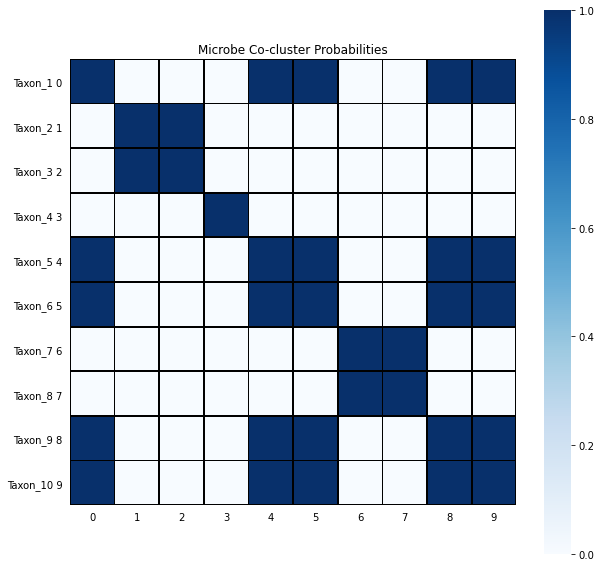

In [23]:
cocluster = clustering.generate_coclusters()
md2.visualization.render_cocluster_probabilities(cocluster, taxa=taxa)

### Cluster properties

The last part of the clustering object are `md2.ClusterProperty` (location in code: `mdsine2.pylab.cluster.Clustering`) objects. These are objects that 
depend on the cluster assignments and need to get updated if the current cluster assignments are changed. Examples of these are the interactions and the perturbations. The way this is done is by an object inheriting the `md2.ClusterProperty` class and specifying these two parameters:
* `signal_when_clusters_change`: If this is True, the `Clustering` object will call the `ClusterProperty.clusters_changed` function in each one of the cluster properties if the number of clusters change. This function has two parameters: `cids_added` `(List[int])` and `cids_removed` `(List[int])`, where they list the cluster IDs that were added and removed, respectively. For examples of this implementation, see `mdsine2.pylab.contrib.Interactions.clusters_changed`.
* `signal_when_item_assignment_changes`: If this is True, the `Clustering` object will call the `ClusterProperty.assignments_cahnged` function in each one of the cluster properties if the assignment of a taxon in the cluster changes __but the number of clusters do not change__. __This function is not used__ in MDSINE2 because the Interactions and perturbations have nothing to do with the specific assignment of each taxon, they only care about the clusters.

## `md2.Interactions` object  <a class="anchor" id="interactionsobject"></a>

An example of a cluster property is the `md2.Interactions` (location in code: `mdsine2.pylab.contrib.Interactions`) object. This object implements the cluster-cluster interactions and has the name `STRNAMES.INTERACTIONS_OBJ`. This has an analogous relationship to the objects in `mdsine2.posterior` and `md2.Clustering` has with `md2.posterior.ClusterAssignments`. `md2.Interactions` is the object that actually changes the interactions while the objects in `mdsine2.posterior` tell it how to change them.

The `Interactions` object can be thought of as an two-level dictionary with some added functionality. The first level of the dictionary indexes the target cluster and the second level indexes the source cluster. __This is the notation that is used in control theory__. Each interaction is an object that has the following properties:
* `source_cid` (`int`) This is the ID of the source cluster
* `target_cid` (`int`): This is the ID of the target cluster
* `value` (`float`): This is the value of the interaction
* `indicator` (`bool`): This is the indicator of the interaction
* `id` (`int`): This is the python ID of the interaction object.

When iterating through the interactions, this is done in cluster order:

In [28]:
interactions = md2.Interactions(clustering=clustering, use_indicators=True)
print('target_cid source_cid')
for interaction in interactions:
    print(interaction.target_cid, interaction.source_cid)

target_cid source_cid
100101 100102
100101 100103
100101 100104
100102 100101
100102 100103
100102 100104
100103 100101
100103 100102
100103 100104
100104 100101
100104 100102
100104 100103


If the order of the clusters change, then this object will automatically reflect that (it looks at `Clustering.order`).

The order of the interactions go as follows:
```python
for target_cid in clustering.order:
    for source_cid in clustering.order:
        if target_cid == source_cid:
            continue
        ...
```
This order is preserved throughout all of inference. This is the order that is used in the regression matrices.

Other that iterating through interactions and specifying the order, the `Interactions` object records the trace of the interactions (negative indicators are set to `NaN`) and reads in/outputs matrices at either the cluster or taxon level.

For description of functions and other types of iteration, see the documentation at `mdsine2.pylab.contrib.Interactions`.

## `md2.BaseMCMC` and `md2.Tracer` object  <a class="anchor" id="basemcmcandtracerobject"></a>

The last major objects are the `md2.BaseMCMC` object (location in code: `mdsine2.pylab.inference.BaseMCMC`) and the `md2.Tracer` object (location in code: `mdsine2.pylab.inference.Tracer`). These objects loop through the gibb steps and record the posteriors into disk, respectively.

### Updating the posterior
The posterior distributions of all the parameters learned in MDSINE2 are implemented in the (rather large) `mdsine2.posterior` module. These are objects are added to `BaseMCMC` and must have the following attributes:
* `add_trace`and `set_trace`: These are functions for recording the values for each Gibb step in the posterior, more details are below in "Recording a trace"
* `update`: This is the function that is called by `BaseMCMC` where the parameter actually implements and samples the posterior distribution. 
If the object does not have these functions, `BaseMCMC` will automatically crash.

### Specifying the inference order
The first thing to do when specifying the `BaseMCMC` object is to specify the inference order. This is a list (in order) of names of the objects where we sample the posterior using the `update` function. More details are below.

In MDSINE2, the overall order is specified in `mdsine2.config.MDSINE2ModelConfig.INFERENCE_ORDER` (`list`). The parameter is set in the inference order if it is flagged to be learned, which is done in `mdsine2.config.MDSINE2ModelConfig.LEARN` (`dict`). 

### Initialization
Initialization functions, which we implement in the `mdsine2.posterior` objects with the fucntion `initialize` __are not required__ to run `BaseMCMC`. This was not made mandatory by `BaseMCMC` for flexibility reasons.

In MDSINE2, initialization is done in the function `mdsine2.run.initialize_graph` in the order specified in `mdsine2.config.MDSINE2ModelConfig.INITIALIZATION_ORDER` (`list`). In this function, the `initialization` function of the object is called with the arguments specified in `mdsine2.config.MDSINE2ModelConfig.INITIALIZATION_KWARGS` (`dict`) for each object respectively. 

### Tracing and setting up the traces in disk

If the inference is long enough, you will not have enough space on RAM to store all of the traces. That is where we use the `Tracer` object. This object is managed by the `BaseMCMC` object and is responsible for writing the posterior samples to disk to clear up space in RAM. Each variable being learned has its own trace in disk where it is stored. The `Tracer` object is rarely used directly by the user directly.

If the user wants to write the traces to disk, which is done with the function `mdsine2.BaseMCMC.set_tracer`, `BaseMCMC` sets up a couple of different things. The first thing it does is it creates the `Tracer` object and tells it to set up disk memory for each variable. The next thing it does it set up a "local trace" (this can be accessed on a variable using `.trace`). This is a small buffer on RAM for a variable to record its trace. Once the buffer is full, the entire buffer is then written to disk. This is done because writing to disk is very slow, so we want to do it as infrequently as possible. In MDSINE2, the local buffer has a default size of 100, which means that we only write to disk every 100 Gibb steps. This number can be larger/smaller depending how much RAM your computer has. This number is specified with the `checkpoint` parameter in `mdsine2.config.MDSINE2ModelConfig`. Note that `checkpoint` must be a multiple of `burnin` (initial number of gibb steps to throw away) and `n_samples` (total number of gibb steps).

All of this writing to disk is done automatically and requires little to no user interference. The function that `BaseMCMC` calls to set up the trace locally and in disk is called `set_trace`. This function is implemented for basic types but needs to be overwritten if an object is comprised of sub-objects (see `mdsine2.posterior.GLVParameters.set_trace` and `mdsine2.posterior.TrajectorySet.set_trace` for examples) or if is an object that is dependent on another (see `mdsine2.posterior.ClusterAssignments` for examples).

To access these values in disk, see below the section [Retrieve trace from disk](#retrievetracefromdisk).

### Recording a trace

Once the posterior is sampled, it is recorded to the local/disk trace using the function `add_trace` on the posterior objects. This function is called automatically by `BaseMCMC` after it calls the function `update`. 

### Looping through gibb steps

The actual loop where all the magic happens in `md2.BaseMCMC.run`. If a run crashes or is stopped by any reason, call the function `md2.BaseMCMC.continue_inference` before you call `md2.BaseMCMC.run`, which will set up the `Tracer` object and `BaseMCMC` object to resume where it had left off.


# Common functionality <a class="anchor" id="commonfunctionality"></a>
If there is a command that is not listed here that you don't know where it is in the code, a way that you can find it is by looking in the `mdsine2.__init__` file. By seeing the module that the function/class is imported from, you can see the location in the code.

The `import` statements in the `__init__` file allow the user to access functions/classes directly from the imported package instead of having to go throughout all of the submodules. For example, instead of loading a `Study` object as
```python
study = md2.pylab.base.Study(...)
```
we can import it directly from the `mdsine2` package:
```python
study = md2.Study(...)
```
We can do this because it is imported in the `__init__` file. 

We can see the location in the code where the `Study` object is implemented by looking in the `__init__` file:
```python
from .pylab.base import ..., Study, ...
```
Note that there are many objects/functions that are imported on the same line.

To find the documentation of the different classes and functions, you can look at the html files `docs` folder of the autogenerated docs. The location of the functions/classes in the docs are the same as their location in the code, so if you don't know the location, then you need to look at the `__init__` file.

In [1]:
import mdsine2 as md2
from mdsine2.names import STRNAMES

### Reading in the Gibson dataset <a class="anchor" id="readinginthegibsondataset"></a>
    
This will automatically try to download this dataset from github. If there is no internet connection, then you can provide a path with the parameter `load_local` that will look in that path for all the files.

* Location in MDSINE2: `MDSINE2.dataset.load_gibson`

*  Command: `study = md2.dataset.load_gibson(...)`

* Example:

   ```python
   # Load healthy
   healthy = md2.dataset.load_gibson(dset='healthy')
   # Load uc
   uc = md2.dataset.load_gibson(dset='uc')
   ```


### Retrieve trace from disk <a class="anchor" id="retrievetracefromdisk"></a>
    
Get the Gibb samples of a variable from disk. This has 3 difference options:
1. `section='posterior'` : This only gets the Gibb samples post-burnin
2. `section='burnin'` : This only gets the Gibb samples used for burnin
3. `section='entire'` : Gets all of the Gibb samples (`burnin` + `posterior`)

* Location in MDSINE2: `MDSINE2.pylab.inference.Tracer.get_trace`

* Example:
    Load using `Tracer` object

    ```python
    mcmc = md2.BaseMCMC.load(path/to/mcmc.pkl)

    # Get the growth parameters from disk of the posterior
    trace = mcmc.tracer.get_trace(name=STRNAMES.GROWTH_VALUE, section='posterior')
    ```

    Load directly from the object

    ```python
    mcmc = md2.BaseMCMC.load(path/to/mcmc.pkl)
    growth = mcmc.graph[STRNAMES.GROWTH_VALUE]

    # Get the growth parameters from disk from the posterior
    trace = growth.get_trace_from_disk(section='posterior')
    ```

    Note that these two are the exact same - the function `get_trace_from_disk` internally calls `tracer.get_trace`
    and passes in its own name. You can call this function for any variable you are tracing during inference
            

### Get statistics of a trace <a class="anchor" id="getstatisticsofatrace"></a>
    
Calculate some statistics of a trace. 

* Automatically calculates and returns a dictionary of:
    * `'mean'`
    * `'median'`
    * `'25th percentile'`
    * `'75th percentile'`

* Location in MDSINE2: `MDSINE2.pylab.variables.summary`

* Command: `md2.summary`

* Example:

    Using objects directly
    ```python
    mcmc = md2.BaseMCMC.load(path/to/mcmc.pkl)
    processvar = mcmc.graph[STRNAMES.PROCESSVAR]
    summ = md2.summary(processvar, section='posterior')
    # Get the mean
    mean = summ['mean']
    ```

    From raw numpy files
    ```python
    mcmc = md2.BaseMCMC.load(path/to/mcmc.pkl)
    processvar = mcmc.graph[STRNAMES.PROCESSVAR]
    trace = processvar.get_trace_from_posterior(section='posterior')
    summ = md2.summary(traces)
    # Get the mean
    mean = summ['mean']
    ```

    Note that these two calls are exactly the same - if you pass in a variable with a trace, it will automatically get the trace from disk by calling the function `get_trace_from_disk`. You can specify the section to retrieve using the `section` parameter.

* Handling NaNs
    By default, `md2.summary` ignores NaNs when calculating the statistics by using the functions `numpy.nanmean`, etc. If you want to set the NaNs to 0s, set the flag `set_nans_to_0=True`

    - Example:
        ```python
        mcmc = md2.BaseMCMC.load(path/to/mcmc.pkl)
        interactions = mcmc.graph[STRNAMES.INTERACTIONS_OBJ]
        ```

        Ignores the NaNs:

        ```python
        trace = md2.summary(interactions)
        ```

        Sets the NaNs to zero:

        ```python
        trace = md2.summary(interactins, set_nan_to_0=True)
        ```

### Defining the parameters of the model <a class="anchor" id="definingtheparametersofthemodel"></a>

* Location in MDSINE2: `MDSINE2.config`

* Command:
    - Logging: `logging = md2.LoggingConfig(...)`
        - This is used to define the logging level and the format to log with.
        - This automatically writes all of the logging to a file that you can view later
    - MDSINE2 parameters: `params = md2.MDSINE2ModelConfig(...)`
        - Defines the parameters to run the MDSINE2 model
    - Negative Binomial dispersion parameters: `params = md2.MDSINE2ModelConfig(...)`
        - Defines the parameters to learn the Negative binomial dispersion parameters

### Bayes factors <a class="anchor" id="bayesfactors"></a>

Generate the bayes factors after the chains have run

- Interactions

    * Location in MDSINE2: `MDSINE2.util.generate_interation_bayes_factors_posthoc`

    * Command: `bf = md2.generate_interation_bayes_factors_posthoc(...)`

    * Example:

    ```python
    mcmc = md2.BaseMCMC.load(path/to/mcmc.pkl)
    bf = md2.generate_interation_bayes_factors_posthoc(mcmc=mcmc, section='posterior')
    ```

- Perturbations

    * Location in MDSINE2: `MDSINE2.util.generate_perturbation_bayes_factors_posthoc`

    * Command: `bf = md2.generate_perturbation_bayes_factors_posthoc(...)`

    * Example:

    ```python
    mcmc = md2.BaseMCMC.load(path/to/mcmc.pkl)
    perturbation = mcmc.graph.perturbations[name_of_perturbation]
    bf = md2.generate_perturbation_bayes_factors_posthoc(
        mcmc=mcmc, perturbation=perturbation, section='posterior')
    ```

### Condensing fixed cluster interactions in perturbations into cluster-cluster interactions <a class="anchor" id="condensingfixedcluster"></a>

- Interactions

    * Location in MDSINE2: `MDSINE2.util.condense_fixed_clustering_interaction_matrix`

    * Command: `M = md2.condense_fixed_clustering_interaction_matrix(...)`

    * Example:

    Generate cluster-cluster interactions for each gibb step

    ```python
    mcmc = md2.BaseMCMC.load(path/to/fixed/clustering/mcmc.pkl)
    clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
    M = mcmc.graph[STRNAMES.INTERACTIONS_OBJ].get_trace_from_disk(
        section='posterior') # (n_gibbs, n_taxa, n_taxa)
    M_condense = md2.condense_fixed_clustering_interaction_matrix(
        M, clustering=clustering) # (n_gibbs, n_clusters, n_clusters)
    ```

    Generate expected cluster-cluster interactions

    ```python
    mcmc = md2.BaseMCMC.load(path/to/fixed/clustering/mcmc.pkl)
    clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
    M = md2.summary(mcmc.graph[STRNAMES.INTERACTIONS_OBJ],
                    set_nan_to_0=True, section='posterior')['mean'] # (n_taxa, n_taxa)
    M_condense = md2.condense_fixed_clustering_interaction_matrix(
        M, clustering=clustering) # (n_clusters, n_clusters)
    ```

    Generate bayes factors of the cluster-cluster interactions

    ```python
    mcmc = md2.BaseMCMC.load(path/to/fixed/clustering/mcmc.pkl)
    clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
    bf = md2.generate_interation_bayes_factors_posthoc(
        mcmc=mcmc, section='posterior') # (n_taxa, n_taxa)
    bf_condensed = md2.condense_fixed_clustering_interaction_matrix(
        bf, clustering=clustering) # (n_clusters, n_clusters)
    ```

    Note that the function can be fed any `n.ndarray` as long as the last 2 dimensions have the shape `(n_taxa, n_taxa)`


- Perturbations

    * Location in MDSINE2: `MDSINE2.util.condense_fixed_clustering_perturbation`

    * Command: `bf = md2.condense_fixed_clustering_perturbation(...)`   
    
    * Example:
    
    Generate cluster perturbations for each gibb step

    ```python
    mcmc = md2.BaseMCMC.load(path/to/fixed/clustering/mcmc.pkl)
    perturbation = mcmc.graph.perturbations[name_of_perturbation]
    M = perturbation.get_trace_from_disk(section='posterior') # (n_gibbs, n_taxa)
    M_condense = md2.condense_fixed_clustering_perturbation(
        M, clustering=clustering) # (n_gibbs, n_clusters)
    ```
    
    Generate expected cluster perturbation values

    ```python
    mcmc = md2.BaseMCMC.load(path/to/fixed/clustering/mcmc.pkl)
    perturbation = mcmc.graph.perturbations[name_of_perturbation]
    M = md2.summary(perturbation,set_nan_to_0=True, section='posterior')['mean'] # (n_taxa, )
    M_condense = md2.condense_fixed_clustering_perturbation(
        M, clustering=clustering) # (n_clusters, )
    ```

    Generate bayes factors of the perturbation

    ```python
    mcmc = md2.BaseMCMC.load(path/to/fixed/clustering/mcmc.pkl)
    clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
    bf = md2.generate_perturbation_bayes_factors_posthoc(
        mcmc=mcmc, perturbation=perturbation, section='posterior') # (n_taxa, )
    bf_condensed = md2.condense_fixed_clustering_perturbation(
        bf, clustering=clustering) # (n_clusters, )
    ```

    Note that the function can be fed any `n.ndarray` as long as the last dimension has the shape `(n_taxa, )`

### Forward simulating <a class="anchor" id="forwardsimulating"></a>

Forward simulate a dynamical system

* Location in MDSINE2: 
    - Definition of the model: `MDSINE2.model.gLVDynamicsSingleClustering`
    - Forward simulation: `MDSINE2.pylab.dynamics.integrate`
* Command:
    - Definition of the model: `md2.gLVDynamicsSingleClustering`
    - Forward simulation: `md2.integrate`
    
* Examples:
    
    Forward simulate the dynamical system in each Gibb step:
    ```python
    mcmc = md2.BaseMCMC.load(path/to/mcmc.pkl)
    
    # Get the initial conditions from  a subject
    subj = md2.Subject.load(path/to/subject.pkl)
    initial_conditions = subj.matrix()['abs'][:, 0]
    
    pred_matrix = md2.gLVDynamicsSingleClustering.forward_sim_from_chain(
        mcmc=mcmc, subjname=subj.name, initial_conditions=initial_conditions,
        times=subj.times, simulation_dt=0.01, section='posterior')
    ```
    
    Initial conditions can come from anywhere, it just needs to be a numpy array with `n_taxa` elements. We do need to pass in a subject name `subjname` so the chain knows which perturbations to use. This function acts as a wrapper for the `gLVDynamicsSingleClustering` and `md2.integrate` and is high level. We can forward simulate a single Gibb step as well with more fine tuning:
    
    Forward simulate for a single gibb step:
    ```python
    
    # Initialize and run the dynamics object
    dyn = md2.gLVDynamicsSingleClustering(
        # np.ndarray(n_taxa), growth parameters
        growth=...,
        # np.ndarray(n_taxa, n_taxa), Interaction matrix (with self-interactions on diagonal)
        interactions=..., 
        # iterable(np.ndarray(n_taxa)), perturbation effects for each perturbation
        perturbations=...,
        # iterable(np.ndarray(float)), start time for each perturbation
        perturbation_starts=...,
        # iterable(np.ndarray(float)), end time for each perturbation
        perturbation_ends=...)
    
    ret = md2.integrate(
        dyn, 
        # np.ndarray(n_taxa, 1) initial abundances
        initial_conditions=..., 
        dt=...,
        n_days=...,
        # If you want to return only certain timepoints
        subsample=True, times=...)
    ```
    
    You can find examples of forward simulation in `MDSINE2_Paper/forward_sim.py`


### Make a name for a taxon <a class="anchor" id="makingnamefortaxon"></a>

You can specify a format in which to write the label of taxa using the function `md2.taxaname_formatter`. With this, you specify what taxonomic information you want where and it will automatically generate the label. This is how the visualization heatmaps generate the labels on the Axes:

* Location in MDSINE2: `mdsine2.pylab.base.taxaname_formatter`
* Command: `mdsine2.taxaname_formatter`
* See documentation for examples and details

### Generating cluster assignments <a class="anchor" id="clusterassignments"></a>

To get the clustering order and to generate the cluster assignments after inference, use the function `md2.generate_cluster_assignments_posthoc`. Note, if you just load a `BaseMCMC` object and get the cluster object, the only time where it is in the right configuration is when we are running with fixed clustering. If we are not running with fixed clustering, the current assignments __are wrong__. You need to call this function to generate the right posterior cluster assignments.
* Location in MDSINE2: `mdsine2.util.generate_cluster_assignments_posthoc`
* Command: `mdsine2.generate_cluster_assignments_posthoc`

